In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from arch import arch_model
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

### Here we train the LSTM neural network used in the AlgoStraddleTrading script
### The model looks at the daily vol and predicts the realized vol over the next 3 days
### In the future, I plan to incoroporate the implied vol surface as well as NLP signals into the model input

In [2]:
def series_to_X_y(df, window_size=5, ahead=1):
  # Will be used to format data
  # Window size denotes number of lags used as predictors
  # Ahead denotes how many days ahead we are predicting
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size - (ahead - 1)):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size+ahead-1]
    y.append(label)
  return np.array(X), np.array(y)

Text(0.5, 1.0, 'NVDA Returns')

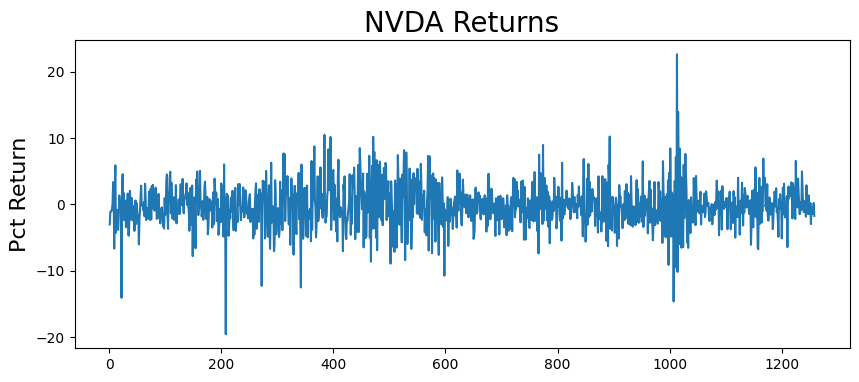

In [3]:
# Visualize returns

nvda = pd.read_csv(r"C:\Users\Xzavier\Documents\Data\Stocks\NVDA\NVDA_324_5Y.csv".replace('\\', '/'))
nvda['Close/Last'] = nvda['Close/Last'].apply(lambda x: x[1:]).astype(float)
returns = 100 * nvda['Close/Last'].pct_change().dropna()
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('NVDA Returns', fontsize=20)

In [4]:
# Prepare and split data
real_vol = returns.rolling(window=7).std().bfill()
WINDOW_SIZE = 7
AHEAD = 3
X1, y1 = series_to_X_y(real_vol, WINDOW_SIZE, AHEAD)
print(X1[0], y1[0])

train = int(.5*len(nvda))
validate = int(.25*len(nvda))
X_train1, y_train1 = X1[:train], y1[:train]
X_val1, y_val1 = X1[train:validate], y1[train:validate]
X_test1, y_test1 = X1[train+validate:], y1[train+validate:]

[[1.94492039]
 [1.94492039]
 [1.94492039]
 [1.94492039]
 [1.94492039]
 [1.94492039]
 [1.94492039]] 3.2256605719657423


In [5]:
# Build the neural network
# This architecture comes from the linked paper

model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(512,return_sequences=True))
model1.add(Dropout(.2))
model1.add(LSTM(256,return_sequences=True))
model1.add(Dropout(.2))
model1.add(LSTM(128))
model1.add(Dropout(.2))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 512)         │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,037,377 (7.77 MB)

 Trainable params: 2,037,377 (7.77 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train using 100 epochs
cp1 = ModelCheckpoint(r'C:\Users\Xzavier\Documents\SpringIEOR\Personal Project\Models/LSTM_3dayVol.keras'.replace('\\', '/'), save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 9.9290 - root_mean_squared_error: 3.1447 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.7164 - root_mean_squared_error: 1.6482

c:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.3115 - root_mean_squared_error: 1.5172 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.5716 - root_mean_squared_error: 1.2509 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1725 - root_mean_squared_error: 1.0800 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.4933 - root_mean_squared_error: 1.2196 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.3957 - root_mean_squared_error: 1.1803 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.4690 - root_mean_squared_error: 1.2117 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 8/100
20/2

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


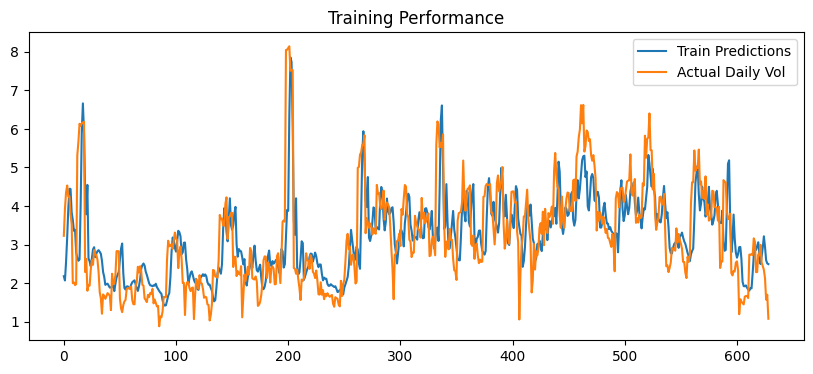

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


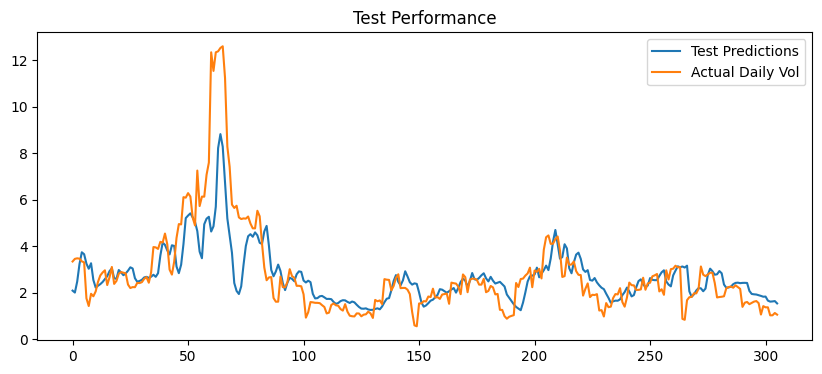

In [7]:
# LSTM performance on training and testing set

train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
plt.figure(figsize=(10,4))
plt.plot(train_results['Train Predictions'], label='Train Predictions')
plt.plot(train_results['Actuals'], label='Actual Daily Vol')
plt.legend()
plt.title('Training Performance')
plt.show()
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
plt.figure(figsize=(10,4))
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.plot(test_results['Actuals'], label='Actual Daily Vol')
plt.legend()
plt.title('Test Performance')
plt.show()

In [8]:
# Correlation between prediciton movements and actual movements
# There is a noticeably high correlation
np.corrcoef(test_results['Actuals'], test_results['Test Predictions'])

array([[1.        , 0.82491378],
       [0.82491378, 1.        ]])

In [9]:
# Single input
y = np.expand_dims(X_test1[0], axis=0)
y

array([[[2.47702963],
        [2.69921461],
        [2.40970891],
        [2.39791458],
        [1.90472337],
        [1.76377165],
        [1.62618996]]])

In [10]:
# Single Prediction
model1.predict(y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[2.0971677]], dtype=float32)